# Visualizing the Corpus of ACL 2017 Paper Titles

There was a significant variation topics covered in long and short papers in ACL 2017.  Below is an application of Scattertext, written up in an ACL 2017 demo paper, on visualizing the differences in these paper titles.

Jason S. Kessler. Scattertext: a Browser-Based Tool for Visualizing how Corpora Differ. To appear in ACL Demos. Vancouver, BC. 2017.

https://github.com/JasonKessler/scattertext

https://arxiv.org/abs/1703.00565

## Let's first, parse the accepted papers blog post using Beautiful Soup and load it into a Pandas data frame

In [176]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
import pygal
import scattertext as st
from IPython.display import IFrame
from IPython.core.display import display, HTML
import seaborn as sns
display(HTML("<style>.container { width:98% !important; }</style>"))
%matplotlib inline

In [108]:
url = 'https://chairs-blog.acl2017.org/2017/04/05/accepted-papers-and-demonstrations/'
soup = BeautifulSoup(requests.get(url).text, 'lxml')
content = soup.find_all('div', class_='entry-content')[0]

def split_authors(author_list):
    return re.split('(?:\W+and|\,)\W+', author_list)

assert split_authors('Sayan Ghosh, Mathieu Chollet, Eugene Laksana, Stefan Scherer and Louis-Philippe Morency') \
    == ['Sayan Ghosh', 'Mathieu Chollet', 'Eugene Laksana', 'Stefan Scherer', 'Louis-Philippe Morency']
assert split_authors('Sayan Ghosh, Mathieu Chollet, Eugene Laksana, Stefan Scherer, and Louis-Philippe Morency') \
    == ['Sayan Ghosh', 'Mathieu Chollet', 'Eugene Laksana', 'Stefan Scherer', 'Louis-Philippe Morency']
    
data = []
for paper_length in content.find_all('h2'):
    length_name = paper_length.text.strip()
    field = 'N/A'
    for sib in paper_length.findNextSiblings():
        if sib.name == 'h2':
            break
        if sib.name == 'h3':
            field = sib.text.strip()
        if sib.name == 'ol':
            for paper in sib.find_all('li'):
                title, authors = paper.text.split('Authors:')
                data.append({'Paper Type': length_name,
                             'Field': field,
                             'Title': title.strip(),
                             'Authors': split_authors(authors.strip())})
df = pd.DataFrame(data)
df['author count'] = df.Authors.apply(len)    

In [109]:
df.iloc[:10]

,Authors,Field,Paper Type,Title,author count
0,"[Leandro Santos, Edilson Anselmo Corrêa Júnior...",Biomedical,Accepted Long Papers,Enriching Complex Networks with Word Embedding...,6
1,"[Gabriel Doyle, Amir Goldberg, Sameer Srivasta...",Cognitive Modelling and Psycholinguistics,Accepted Long Papers,Alignment at Work: Using Language to Distingui...,4
2,"[Grzegorz Chrupała, Lieke Gelderloos, Afra Ali...",Cognitive Modelling and Psycholinguistics,Accepted Long Papers,Representations of language in a model of visu...,3
3,"[Yang Xu, David Reitter]",Cognitive Modelling and Psycholinguistics,Accepted Long Papers,Spectral Analysis of Information Density in Di...,2
4,"[Young-Bum Kim, Karl Stratos, Dongchan Kim]",Dialog Interactive Systems,Accepted Long Papers,Adversarial Adaptation of Synthetic or Stale Data,3
5,"[Sayan Ghosh, Mathieu Chollet, Eugene Laksana,...",Dialog Interactive Systems,Accepted Long Papers,Affect-LM: A Neural Language Model for Customi...,5
6,"[Satoshi Akasaki, Nobuhiro Kaji]",Dialog Interactive Systems,Accepted Long Papers,Chat Detection in Intelligent Assistant: Combi...,2
7,"[Young-Bum Kim, Karl Stratos, Dongchan Kim]",Dialog Interactive Systems,Accepted Long Papers,Domain Attention with an Ensemble of Experts,3
8,"[Martin Villalba, Christoph Teichmann, Alexand...",Dialog Interactive Systems,Accepted Long Papers,Generating Contrastive Referring Expressions,3
9,"[Jason D Williams, Kavosh Asadi, Geoffrey Zweig]",Dialog Interactive Systems,Accepted Long Papers,Hybrid Code Networks: practical and efficient ...,3


## Let's use Scattertext to see how the titles of long and short papers differ
End-to-end modeling, joint modeling, adversarial learning, and reading comprehension were particularly characteristic of long papers. 

Case studies, social media, multilingual analysis and were more prevalent in short papers. The term "temporal" fell victim to polysemy-- both temporal relation mining and trend-over-time analysis were common in short papers.

Learning, neural, and translation were very common in both sets. 

Click around on the plot below to see other findings.

In [174]:
df['Parsed'] = df['Title'].apply(st.whitespace_nlp)
long_short_df = df[df['Paper Type'].isin(['Accepted Long Papers', 'Accepted Short Papers'])]
long_short_corpus = (st.CorpusFromParsedDocuments(long_short_df, 
                                                  category_col = 'Paper Type', 
                                                  parsed_col = 'Parsed', 
                                                  feats_from_spacy_doc = st.FeatsFromSpacyDoc(strip_final_period=True))
                     .build()
                     .get_stoplisted_unigram_corpus())
html = st.produce_scattertext_explorer(long_short_corpus, 
                                       category='Accepted Long Papers', 
                                       category_name='Long Papers', 
                                       not_category_name='Short Papers',
                                       minimum_term_frequency=1,
                                       metadata=long_short_df.apply(lambda x: ', '.join(x['Authors']) + '('+x['Field']+')', axis=1),
                                       use_full_doc=True,
                                       width_in_pixels=1000)
file_name = "ACL2017LongShort.html"
open(file_name, 'wb').write(html.encode('utf-8'))
IFrame(src=file_name, width = 1200, height=1000)

## Let's look at some descriptive statistics about the set accepted papers, and look at variations in paper categories
The vast majority of papers are long papers. MT, Semantics, and Gen. Summarization were more associated with Long Papers, while ML, Social Media, and Multidisciplinary dominated short papers. 

In [110]:
HTML(pygal.HorizontalStackedBar(explicit_size=5, 
                                height=100,
                                x_labels = list(df['Paper Type'].value_counts().index),
                                style=pygal.style.DefaultStyle(value_font_size=10), print_values=True)
     .add('Paper Type', df['Paper Type'].value_counts())
     .render(is_unicode=True))

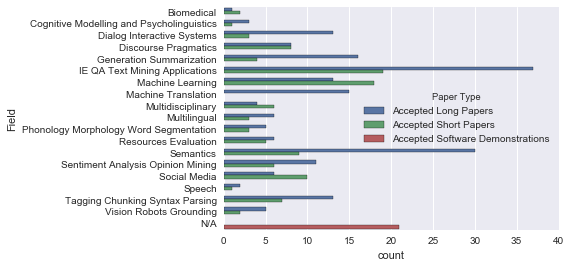

In [175]:
pct_df['Field %'] = pct_df['Title_x']/pct_df['Title_y']
type_field_df = df.groupby(['Paper Type', 'Field'])['Title'].count().reset_index()
type_field_df.columns = ['Count' if c == 'Title' else c for c in type_field_df.columns]
_=sns.countplot(data=df, y='Field', hue='Paper Type')

In [169]:
long_short_type_field_df = (type_field_df[type_field_df['Paper Type'].isin(('Accepted Long Papers', 'Accepted Short Papers'))]
                            .pivot(index='Field',columns='Paper Type')['Count'].fillna(0).astype(int))

data = [{'value': tuple(vals), 'label': lab} for vals, lab in zip(long_short_type_field_df.values, long_short_type_field_df.index)]
chart = (pygal
     .XY(print_labels=True, print_values=True, stroke=False, legend_at_bottom=True, x_title='Long Papers', y_title="Short Papers",
         style=pygal.style.DefaultStyle(value_font_size=10, label_font_size=10,legend_font_size=10, value_label_font_size=10, major_label_font_size=10), explicit_size=10))

for vals, lab in zip(long_short_type_field_df.values, long_short_type_field_df.index):
    chart.add(lab, [{'value':vals,'label':lab[:20]}])
HTML(chart.render(is_unicode=True))